In [ ]:
!unrar x "/content/2E-EVRP-Instances-v2.rar" "/content/2E-EVRP-Instances-v2/"





UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/2E-EVRP-Instances-v2.rar

Creating    /content/2E-EVRP-Instances-v2                             OK
Creating    /content/2E-EVRP-Instances-v2/2E-EVRP-Instances-v2        OK
Creating    /content/2E-EVRP-Instances-v2/2E-EVRP-Instances-v2/manilakbay-2E-EVRP-Instances-dc2c2d0  OK
Extracting  /content/2E-EVRP-Instances-v2/2E-EVRP-Instances-v2/manilakbay-2E-EVRP-Instances-dc2c2d0/README.md       0%  OK 
Creating    /content/2E-EVRP-Instances-v2/2E-EVRP-Instances-v2/manilakbay-2E-EVRP-Instances-dc2c2d0/Type_x  OK
Creating    /content/2E-EVRP-Instances-v2/2E-EVRP-Instances-v2/manilakbay-2E-EVRP-Instances-dc2c2d0/Type_x/Customer_10  OK
Extracting  /content/2E-EVRP-Instances-v2/2E-EVRP-Instances-v2/manilakbay-2E-EVRP-Instances-dc2c2d0/Type_x/Customer_10/C101_C10x.txt       0%  OK 
Extracting  /content/2E-EVRP-Instances-v2/2E-EVRP-Instances-v2/manilakbay-2E-EVRP-Instances-dc2c2d0/

In [6]:
import os

for root, dirs, files in os.walk("/content/2E-EVRP-Instances-v2"):
    print(root, dirs, files)
    break


/content/2E-EVRP-Instances-v2 ['manilakbay-2E-EVRP-Instances-dc2c2d0'] []


In [5]:
!apt-get install unrar
!unrar x 2E-EVRP-Instances-v2.rar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from 2E-EVRP-Instances-v2.rar

Creating    2E-EVRP-Instances-v2                                      OK
Creating    2E-EVRP-Instances-v2/manilakbay-2E-EVRP-Instances-dc2c2d0  OK
Extracting  2E-EVRP-Instances-v2/manilakbay-2E-EVRP-Instances-dc2c2d0/README.md       0%  OK 
Creating    2E-EVRP-Instances-v2/manilakbay-2E-EVRP-Instances-dc2c2d0/Type_x  OK
Creating    2E-EVRP-Instances-v2/manilakbay-2E-EVRP-Instances-dc2c2d0/Type_x/Customer_10  OK
Extracting  2E-EVRP-Instances-v2/manilakbay-2E-EVRP-Instances-dc2c2d0/Type_x/Customer_10/C101_C10x.txt       0%  OK 
Extracting  2E-EVRP-Instances-v2/manilakbay-2E-EVRP-Instances-dc2c2d0/Type_x/Customer_10/C102_C10x_n.txt      

Instance chargée : C105_C15x_n.txt
Nombre de clients : 15
Capacité véhicule (C) : 100.0 | Capacité batterie (Q) : 79.69

✅ Simulated Annealing terminé !

🏆 Meilleur coût trouvé : 76060.63
🚚 Nombre de routes utilisées : 3
⏱️ Temps d'exécution : 0.043 secondes



Route,Arrêts,Chemin
Route 1,7,DepotD0 → Station fF12 (f) → ClientC0 (c) → ClientC94 (c) → ClientC43 (c) → ClientC30 (c) → ClientC3 (c) → ClientC98 (c) → DepotD0
Route 2,6,DepotD0 → Station fF12 (f) → ClientC62 (c) → ClientC22 (c) → ClientC28 (c) → ClientC47 (c) → ClientC77 (c) → DepotD0
Route 3,5,DepotD0 → Station fF12 (f) → ClientC64 (c) → ClientC85 (c) → ClientC75 (c) → ClientC46 (c) → DepotD0


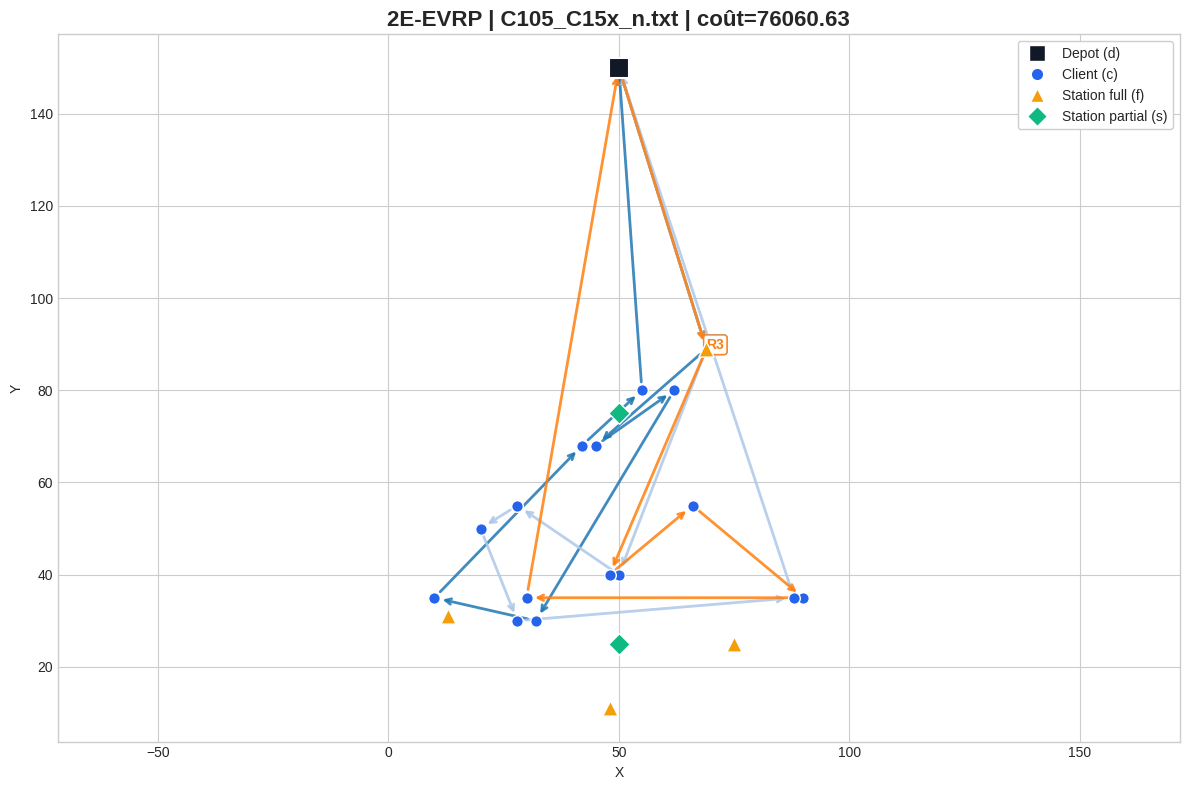

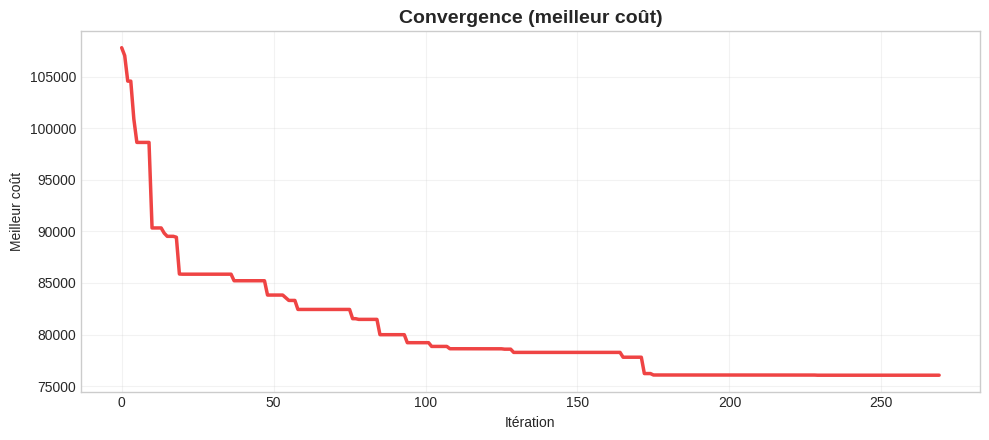

In [10]:
# ============================================================
# SIMULATED ANNEALING (SA) - 2E-EVRP
# Version autonome (Colab) + affichage moderne des routes (HTML + plot)
# ============================================================

import math
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from IPython.display import display, HTML

# ----------------------------
# Lecture de l'instance
# ----------------------------
def read_instance(filepath):
    nodes = []
    C = Q = 200.0

    with open(filepath, "r") as f:
        lines = [l.strip() for l in f.readlines()]

    for l in lines:
        if l.startswith("C "):
            C = float(l.split('/')[1].strip())
        elif l.startswith("Q "):
            Q = float(l.split('/')[1].strip())

    start_idx = next((i for i, l in enumerate(lines) if l.startswith("StringID")), 0)

    for line in lines[start_idx + 1:]:
        parts = line.split()
        if len(parts) < 11 or parts[1] not in ('d', 'c', 'f', 's'):
            continue

        nodes.append({
            'id': parts[0],
            'type': parts[1],
            'x': float(parts[2]),
            'y': float(parts[3]),
            'demand': float(parts[4]),
            'division_rate': float(parts[7]),
            'ready_time': float(parts[8]),
            'due_date': float(parts[9]),
            'service_time': float(parts[10])
        })

    # dépôt en premier
    nodes.sort(key=lambda n: 0 if n['type'] == 'd' else 1)
    return nodes, C, Q


# ----------------------------
# Outils
# ----------------------------
def distance(a, b):
    return math.hypot(a['x'] - b['x'], a['y'] - b['y'])


def sequence_to_routes(sequence, nodes, C, Q, rechs):
    routes, route = [], []
    load, battery, prev_idx = 0.0, Q, 0

    for c_idx in sequence:
        cust = nodes[c_idx]

        # contrainte capacité
        if load + cust['demand'] > C:
            if route:
                routes.append(route)
            route, load, battery, prev_idx = [], 0.0, Q, 0

        needed = distance(nodes[prev_idx], cust) * cust['division_rate']

        # contrainte batterie -> tentative d'insérer une station
        if needed > battery:
            valid = [r for r in rechs
                     if distance(nodes[prev_idx], nodes[r]) * nodes[r]['division_rate'] <= battery]
            if valid:
                rech = min(valid, key=lambda x: distance(nodes[prev_idx], nodes[x]))
                route.append(rech)
                battery = Q
                prev_idx = rech

        route.append(c_idx)
        battery -= distance(nodes[prev_idx], cust) * cust['division_rate']
        load += cust['demand']
        prev_idx = c_idx

    if route:
        routes.append(route)

    return routes


def objective_function(routes, nodes, C, Q):
    total_dist, total_penalty = 0.0, 0.0

    for route in routes:
        prev, battery, time_val, load = nodes[0], Q, 0.0, 0.0

        for idx in route:
            n = nodes[idx]
            d = distance(prev, n)
            total_dist += d

            battery -= d * n['division_rate']
            time_val = max(time_val + d, n['ready_time'])

            if time_val > n['due_date']:
                total_penalty += (time_val - n['due_date']) * 5

            time_val += n['service_time']
            load += n['demand']

            if load > C or battery < 0:
                total_penalty += 5000

            if n['type'] in ('f', 's'):
                battery = Q

            prev = n

        total_dist += distance(prev, nodes[0])

    return total_dist + total_penalty


# ----------------------------
# Simulated Annealing
# ----------------------------
def run_sa(nodes, C, Q, iterations=300, seed=42):
    random.seed(seed)

    custs = [i for i, n in enumerate(nodes) if n['type'] == 'c']
    rechs = [i for i, n in enumerate(nodes) if n['type'] in ('f', 's')]

    current_seq = random.sample(custs, len(custs))
    current_routes = sequence_to_routes(current_seq, nodes, C, Q, rechs)
    current_cost = objective_function(current_routes, nodes, C, Q)

    best_sol, best_cost = current_routes, current_cost
    history = []

    T, alpha = 1000.0, 0.95

    for _ in range(iterations):
        neighbor = current_seq[:]
        i, j = random.sample(range(len(neighbor)), 2)
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]

        neigh_routes = sequence_to_routes(neighbor, nodes, C, Q, rechs)
        neigh_cost = objective_function(neigh_routes, nodes, C, Q)

        delta = neigh_cost - current_cost

        if delta < 0 or random.random() < math.exp(-delta / max(T, 1e-6)):
            current_seq, current_cost = neighbor, neigh_cost
            if current_cost < best_cost:
                best_cost, best_sol = current_cost, neigh_routes

        history.append(best_cost)
        T *= alpha
        if T < 1e-3:
            break

    return best_sol, best_cost, history


# ----------------------------
# Affichage moderne (Colab)
# ----------------------------
def _node_style(n_type):
    if n_type == 'd':  # depot
        return dict(color="#111827", s=220, marker="s", edgecolor="white", linewidth=1.5, zorder=5)
    if n_type == 'c':  # client
        return dict(color="#2563EB", s=70, marker="o", edgecolor="white", linewidth=1.0, zorder=4)
    if n_type == 'f':  # station full
        return dict(color="#F59E0B", s=120, marker="^", edgecolor="white", linewidth=1.0, zorder=4)
    if n_type == 's':  # station partial
        return dict(color="#10B981", s=120, marker="D", edgecolor="white", linewidth=1.0, zorder=4)
    return dict(color="#6B7280", s=60, marker="o", edgecolor="white", linewidth=1.0, zorder=3)


def plot_routes_modern(nodes, best_solution, title="Routes (SA)"):
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(12, 8))

    # points par type
    for t in ['d', 'c', 'f', 's']:
        xs = [n['x'] for n in nodes if n['type'] == t]
        ys = [n['y'] for n in nodes if n['type'] == t]
        if xs:
            ax.scatter(xs, ys, **_node_style(t))

    # routes (flèches)
    cmap = plt.get_cmap("tab20")
    for r_idx, route in enumerate(best_solution):
        color = cmap(r_idx % 20)
        path = [0] + route + [0]

        for a, b in zip(path[:-1], path[1:]):
            na, nb = nodes[a], nodes[b]
            ax.annotate(
                "",
                xy=(nb['x'], nb['y']),
                xytext=(na['x'], na['y']),
                arrowprops=dict(arrowstyle="->", color=color, lw=2, alpha=0.85, shrinkA=6, shrinkB=6),
                zorder=2
            )

        if route:
            first = nodes[route[0]]
            ax.text(
                first['x'], first['y'], f"R{r_idx+1}",
                fontsize=10, fontweight="bold", color=color,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color, alpha=0.9)
            )

    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect("equal", adjustable="datalim")
    ax.margins(0.08)

    legend_elems = [
        Line2D([0],[0], marker='s', color='w', label='Depot (d)',
               markerfacecolor=_node_style('d')['color'], markeredgecolor='white', markersize=11),
        Line2D([0],[0], marker='o', color='w', label='Client (c)',
               markerfacecolor=_node_style('c')['color'], markeredgecolor='white', markersize=9),
        Line2D([0],[0], marker='^', color='w', label='Station full (f)',
               markerfacecolor=_node_style('f')['color'], markeredgecolor='white', markersize=10),
        Line2D([0],[0], marker='D', color='w', label='Station partial (s)',
               markerfacecolor=_node_style('s')['color'], markeredgecolor='white', markersize=10),
    ]
    ax.legend(handles=legend_elems, loc="upper right", frameon=True, framealpha=0.95)

    plt.tight_layout()
    plt.show()


def routes_to_html(nodes, best_solution):
    badge = {
        'd': ('Depot', '#111827'),
        'c': ('Client', '#2563EB'),
        'f': ('Station f', '#F59E0B'),
        's': ('Station s', '#10B981'),
    }

    def pill(t):
        name, col = badge.get(t, ('?', '#6B7280'))
        return f"<span style='display:inline-block;padding:2px 8px;border-radius:999px;background:{col};color:white;font-size:12px;margin-right:6px'>{name}</span>"

    rows = []
    for i, route in enumerate(best_solution, 1):
        stops = []
        for idx in route:
            n = nodes[idx]
            stops.append(f"{pill(n['type'])}<b>{n['id']}</b> <span style='color:#6B7280'>({n['type']})</span>")
        route_html = " <span style='color:#9CA3AF'>→</span> ".join(stops) if stops else "<i>vide</i>"
        rows.append(f"""
          <tr>
            <td style="padding:10px;border-bottom:1px solid #E5E7EB"><b>Route {i}</b></td>
            <td style="padding:10px;border-bottom:1px solid #E5E7EB">{len(route)}</td>
            <td style="padding:10px;border-bottom:1px solid #E5E7EB">
              {pill('d')}<b>{nodes[0]['id']}</b>
              <span style='color:#9CA3AF'>→</span>
              {route_html}
              <span style='color:#9CA3AF'>→</span>
              {pill('d')}<b>{nodes[0]['id']}</b>
            </td>
          </tr>
        """)

    html = f"""
    <div style="font-family:system-ui,-apple-system,Segoe UI,Roboto,Ubuntu,Cantarell,Noto Sans,sans-serif">
      <div style="display:flex;justify-content:space-between;align-items:flex-end;margin:12px 0">
        <div>
          <div style="font-size:18px;font-weight:800;color:#111827">Détail des routes</div>
          <div style="color:#6B7280;font-size:13px">Affichage lisible (Colab)</div>
        </div>
        <div style="color:#111827;background:#F3F4F6;border:1px solid #E5E7EB;border-radius:10px;padding:8px 10px;font-size:13px">
          Routes: <b>{len(best_solution)}</b>
        </div>
      </div>
      <div style="border:1px solid #E5E7EB;border-radius:14px;overflow:hidden">
        <table style="width:100%;border-collapse:collapse">
          <thead style="background:#F9FAFB">
            <tr>
              <th style="text-align:left;padding:10px;border-bottom:1px solid #E5E7EB">Route</th>
              <th style="text-align:left;padding:10px;border-bottom:1px solid #E5E7EB">Arrêts</th>
              <th style="text-align:left;padding:10px;border-bottom:1px solid #E5E7EB">Chemin</th>
            </tr>
          </thead>
          <tbody>
            {''.join(rows)}
          </tbody>
        </table>
      </div>
    </div>
    """
    display(HTML(html))


def plot_convergence_modern(history):
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(10, 4.5))
    ax.plot(history, color="#EF4444", lw=2.5)
    ax.set_title("Convergence (meilleur coût)", fontsize=14, fontweight="bold")
    ax.set_xlabel("Itération")
    ax.set_ylabel("Meilleur coût")
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()


# ----------------------------
# EXECUTION (COLAB)
# ----------------------------
file_path = "/content/2E-EVRP-Instances-v2/manilakbay-2E-EVRP-Instances-dc2c2d0/Type_x/Customer_15/C105_C15x_n.txt"  # <-- modifie si besoin

# Chargement
nodes, C, Q = read_instance(file_path)

print(f"Instance chargée : {file_path.split('/')[-1]}")
print(f"Nombre de clients : {len([n for n in nodes if n['type']=='c'])}")
print(f"Capacité véhicule (C) : {C} | Capacité batterie (Q) : {Q}\n")

# SA
start = time.time()
best_solution, best_cost, history = run_sa(nodes, C, Q, iterations=1000, seed=42)
elapsed = time.time() - start

print("✅ Simulated Annealing terminé !\n")
print(f"🏆 Meilleur coût trouvé : {best_cost:.2f}")
print(f"🚚 Nombre de routes utilisées : {len(best_solution)}")
print(f"⏱️ Temps d'exécution : {elapsed:.3f} secondes\n")

# Affichage moderne
routes_to_html(nodes, best_solution)
plot_routes_modern(nodes, best_solution, title=f"2E-EVRP | {file_path.split('/')[-1]} | coût={best_cost:.2f}")
plot_convergence_modern(history)